In [1]:
############################################################
# Plots of meta-stable Maxwell loops
# Inspired by https://doi.org/10.1134/S0036024406040030
# Math tricks taken from: http://math.stackexchange.com/q/416823/92706
# Plot also shown on page 79 of https://doi.org/10.15480/882.1207
############################################################

# load some bits and pieces
import numpy as np
from numpy.linalg import solve
from numpy.linalg import lstsq
from numpy import log

import matplotlib
import matplotlib.pyplot as plt

import CoolProp as CP
from CoolProp.CoolProp import PropsSI

# Check: CoolProp version
print(CP.__version__)
print(CP.__gitrevision__)

# Constants
eps = 1e-3
kilo = 1e3
Mega = 1e6
golden = (1 + 5 ** 0.5) / 2
width = 12.5

6.3.0
ba41b1434002b1fce6e596386861bca2a890fb6f


In [2]:
# Set FluidName
FluidName = 'CO2'
nPoints = 1000
# pick any int smaller than nPoints
myIdx = 860 

# Constants, triple and critical data
R = PropsSI('GAS_CONSTANT',FluidName)
MM = PropsSI('MOLAR_MASS',FluidName)
Rs = R/MM
T_crt = PropsSI('T_CRITICAL',FluidName)
T_trp = PropsSI('T_TRIPLE',FluidName)
p_crt = PropsSI('P_CRITICAL',FluidName)
p_trp = PropsSI('P_TRIPLE',FluidName)
p_max = PropsSI('P_MAX',FluidName)
d_crt = PropsSI('RHOMASS_CRITICAL',FluidName)
v_crt = 1/d_crt
d_trp_liq = PropsSI('D','T',T_trp,'Q',0,FluidName)
d_trp_vap = PropsSI('D','T',T_trp,'Q',1,FluidName)
print("R = " + str(R))
print("MM = " + str(MM))
print("Rs = " + str(Rs))
print("T_crt = " + str(T_crt))
print("T_trp = " + str(T_trp))

R = 8.31451
MM = 0.0440098
Rs = 188.92405782348476
T_crt = 304.1282
T_trp = 216.592


In [ ]:
# Calculation of the coefficients for the metastable region interpolation happens in this cell

T_sat = np.linspace(T_trp, T_crt-eps, num=nPoints)
# empty arrays
# vap side
delta_vap = np.empty(nPoints)
tau_vap = np.empty(nPoints)
p_vap = np.empty(nPoints)
d_vap = np.empty(nPoints)
v_vap = np.empty(nPoints)
f_vap = np.empty(nPoints)
dP_dD_T_vap = np.empty(nPoints)
d2P_dD2_T_vap = np.empty(nPoints)
d2P_dDdT_vap = np.empty(nPoints)
# liq side
delta_liq = np.empty(nPoints)
tau_liq = np.empty(nPoints)
p_liq = np.empty(nPoints)
d_liq = np.empty(nPoints)
v_liq = np.empty(nPoints)
f_liq = np.empty(nPoints)
dP_dD_T_liq = np.empty(nPoints)
d2P_dD2_T_liq = np.empty(nPoints)
d2P_dDdT_liq = np.empty(nPoints)
# metastable coeffs: 
AShape = (8,8)
A = np.empty(AShape)
b = np.empty(8)
xShape = (nPoints,8)
x = np.empty(xShape)

HEOS = CP.AbstractState("HEOS", FluidName)
# get values from CoolProp
for idx in range(0,nPoints):
    # AT the vap line
    HEOS.update(CP.QT_INPUTS, 1, T_sat[idx])  
    delta_vap[idx] = HEOS.delta() 
    tau_vap[idx] = HEOS.tau()
    p_vap[idx] = HEOS.p()
    d_vap[idx] = HEOS.rhomass()
    f_vap[idx] = Rs*T_sat[idx]*( HEOS.alpha0() + HEOS.alphar() )    
    #f_vap[idx] = HEOS.umass() - T_sat[idx]*HEOS.smass()
    dP_dD_T_vap[idx] = HEOS.first_partial_deriv(CP.iP, CP.iDmass, CP.iT)
    d2P_dD2_T_vap[idx] = HEOS.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iDmass, CP.iT)
    d2P_dDdT_vap[idx] = HEOS.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iT, CP.iDmass)     
    
    # AT the liq line
    HEOS.update(CP.QT_INPUTS, 0, T_sat[idx])  
    delta_liq[idx] = HEOS.delta() 
    tau_liq[idx] = HEOS.tau()
    p_liq[idx] = HEOS.p() 
    d_liq[idx] = HEOS.rhomass() 
    f_liq[idx] = Rs*T_sat[idx]*( HEOS.alpha0() + HEOS.alphar() )
    # f_liq[idx] = HEOS.umass() - T_sat[idx]*HEOS.smass()
    dP_dD_T_liq[idx] = HEOS.first_partial_deriv(CP.iP, CP.iDmass, CP.iT)
    d2P_dD2_T_liq[idx] = HEOS.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iDmass, CP.iT)   
    d2P_dDdT_liq[idx] = HEOS.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iT, CP.iDmass)   

    # calculate metastable coeffs by solving Ax=b
    A = np.array([  [1/tau_vap[idx], -1/delta_vap[idx]/tau_vap[idx],  log(delta_vap[idx]),          delta_vap[idx],     delta_vap[idx]**2/2,       delta_vap[idx]**3/3,         delta_vap[idx]**4/4,        delta_vap[idx]**5/5 ], 
                    [1/tau_liq[idx], -1/delta_liq[idx]/tau_liq[idx],  log(delta_liq[idx]),          delta_liq[idx],     delta_liq[idx]**2/2,       delta_liq[idx]**3/3,         delta_liq[idx]**4/4,        delta_liq[idx]**5/5 ], 
                    [             0,             d_crt/tau_vap[idx], d_crt*delta_vap[idx], d_crt*delta_vap[idx]**2, d_crt*delta_vap[idx]**3,    d_crt*delta_vap[idx]**4,    d_crt*delta_vap[idx]**5,    d_crt*delta_vap[idx]**6 ], 
                    [             0,             d_crt/tau_liq[idx], d_crt*delta_liq[idx], d_crt*delta_liq[idx]**2, d_crt*delta_liq[idx]**3,    d_crt*delta_liq[idx]**4,    d_crt*delta_liq[idx]**5,    d_crt*delta_liq[idx]**6 ], 
                    [             0,                              0,                    1,        2*delta_vap[idx],     3*delta_vap[idx]**2,        4*delta_vap[idx]**3,        5*delta_vap[idx]**4,        6*delta_vap[idx]**5 ], 
                    [             0,                              0,                    1,        2*delta_liq[idx],     3*delta_liq[idx]**2,        4*delta_liq[idx]**3,        5*delta_liq[idx]**4,        6*delta_liq[idx]**5 ], 
                    [             0,                              0,                    0,                 2/d_crt,  6*delta_vap[idx]/d_crt, 12*delta_vap[idx]**2/d_crt, 20*delta_vap[idx]**3/d_crt, 30*delta_vap[idx]**4/d_crt ], 
                    [             0,                              0,                    0,                 2/d_crt,  6*delta_liq[idx]/d_crt, 12*delta_liq[idx]**2/d_crt, 20*delta_liq[idx]**3/d_crt, 30*delta_liq[idx]**4/d_crt ]])
    A = Rs*T_crt*A
    b = np.array([f_vap[idx], f_liq[idx], p_vap[idx], p_liq[idx], dP_dD_T_vap[idx], dP_dD_T_liq[idx], d2P_dD2_T_vap[idx], d2P_dD2_T_liq[idx]])
    x[idx] = solve(A,b)
    
    # for validation
    if (abs(idx-myIdx)<0.9):
        print(np.allclose(np.dot(A, x[idx]), b))
        print(A)
        print(b)
        print(x[idx])


In [ ]:
# Just some validation plots
plt.figure(figsize=(width,width*4/2/golden))

plt.subplot(4,2,1)
plt.plot(T_sat, f_vap, color='red')
plt.plot(T_sat, f_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.ylabel('Helmholtz energy')

plt.subplot(4,2,2)
plt.plot(d_vap, T_sat, color='red')
plt.plot(d_liq, T_sat, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel('Density in kg/m³')
plt.ylabel('Temperature in K')

plt.subplot(4,2,3)
plt.plot(T_sat, p_vap, color='red')
plt.plot(T_sat, p_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.ylabel('Pressure in Pa')

plt.subplot(4,2,4)
plt.plot(d_vap, p_vap, color='red')
plt.plot(d_liq, p_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel('Density in kg/m³')
plt.ylabel('Pressure in Pa')

plt.subplot(4,2,5)
plt.plot(T_sat, dP_dD_T_vap, color='red')
plt.plot(T_sat, dP_dD_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.yscale('log')
plt.ylabel('dP_dD_T')

plt.subplot(4,2,6)
plt.plot(d_vap, dP_dD_T_vap, color='red')
plt.plot(d_liq, dP_dD_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.yscale('log')
plt.xlabel('Density in kg/m³')
plt.ylabel('dP_dD_T')

plt.subplot(4,2,7)
plt.plot(T_sat, d2P_dD2_T_vap, color='red')
plt.plot(T_sat, d2P_dD2_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.ylabel('d2P_dD2_T')
plt.xlabel('Temperature in K')

plt.subplot(4,2,8)
plt.plot(d_vap, d2P_dD2_T_vap, color='red')
plt.plot(d_liq, d2P_dD2_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel('Density in kg/m³')
plt.ylabel('d2P_dD2_T')

tau_iso = 1.0417217720566936
T_iso = 291.94762762762764
p_sat(T_iso) = 5569191.928520719
d_vap(T_iso) = 185.17587066325405
d_liq(T_iso) = 785.8632178765519
coeffs = [-0.38011836 -0.0331094   1.21278872 -2.00233849  1.1397745   0.285719
 -0.5838537   0.17728102]


Text(0.5, 0, '$v/v_c$')

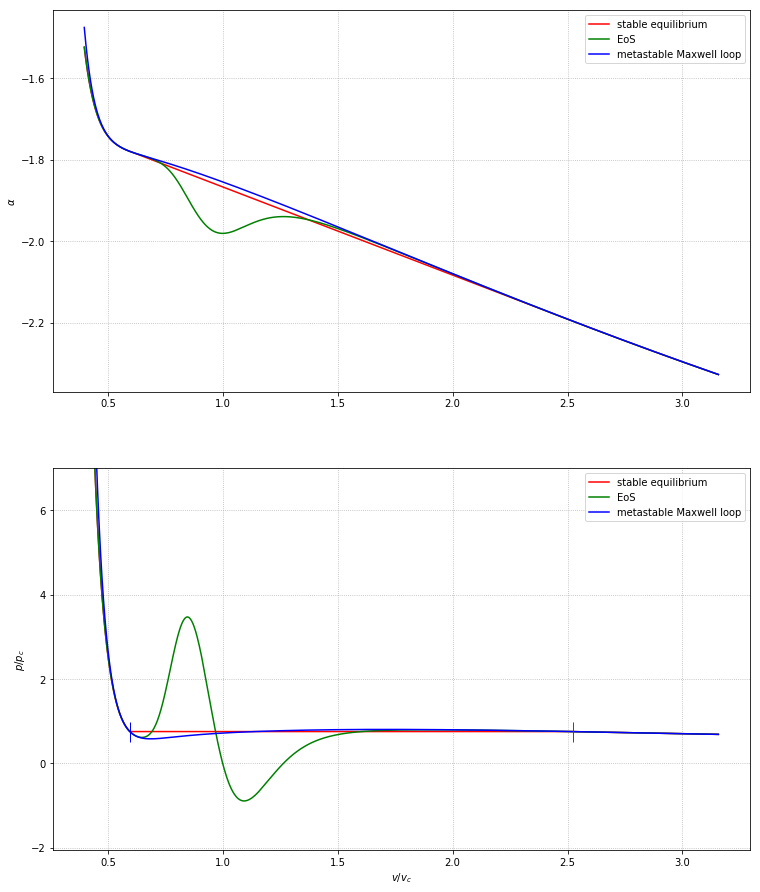

In [5]:
# This cell is for plotting the Maxwell loops along one specified isotherm (chosen with myIdx)
T_iso = T_sat[myIdx]
tau_iso = T_crt/T_iso
p_iso = p_vap[myIdx]
print("tau_iso = " + str(tau_iso))
print("T_iso = " + str(T_iso))
print("p_sat(T_iso) = " + str(p_iso))
print("d_vap(T_iso) = " + str(d_vap[myIdx]))
print("d_liq(T_iso) = " + str(d_liq[myIdx]))

# copy coeffs of that single point
c = x[myIdx,:]
print("coeffs = " + str(c))
      
# get a density range
d_min = 0.8*d_vap[myIdx] 
#d_min = d_trp_vap
# d_max = 1.9*d_liq[myIdx]
d_max = PropsSI('D','T',T_iso,'P',p_max,FluidName)
d_max = d_trp_liq
rhos = np.linspace(d_min, d_max, num=nPoints)
deltas = rhos/d_crt
# for plotting, we will use volume (d_min is high v, d_max is low v)
vs = 1/rhos

# calculate Helmholtz energy and pressure for that density range, at T_iso
# stable
fs = np.ones(nPoints)
ps = np.ones(nPoints)
# equation of state, without chacking phase
fes = np.ones(nPoints)
pes = np.ones(nPoints)
# meta-stable
fms = np.ones(nPoints)
pms = np.ones(nPoints)
for idx in range(0,nPoints):
    # stable
    HEOS.unspecify_phase()
    HEOS.update(CP.DmassT_INPUTS, rhos[idx], T_iso)  
    #fs[idx] = Rs*T_iso*(HEOS.alpha0() + HEOS.alphar())
    fs[idx] = HEOS.umass() - T_iso*HEOS.smass()
    ps[idx] = HEOS.p()
    # eos
    HEOS.specify_phase(CP.iphase_liquid)
    HEOS.update(CP.DmassT_INPUTS, rhos[idx], T_iso)
    fes[idx] = HEOS.umass() - T_iso*HEOS.smass()
    pes[idx] = HEOS.p()
    # meta stable interpolation
    # p = -(df/dv)_T
    # s = -(df/dT)_v
    # cv = T*(ds/dT)_v = -T*(dsf/dT2)_v
    fms[idx]  = Rs*T_crt*( +c[0]/tau_iso -c[1]/tau_iso/deltas[idx] +c[2]*log(deltas[idx]) +c[3]*deltas[idx]    +c[4]*deltas[idx]**2/2 +c[5]*deltas[idx]**3/3 +c[6]*deltas[idx]**4/4 +c[7]*deltas[idx]**5/5 )
    pms[idx]  = Rs*T_crt*d_crt*( 0       +c[1]/tau_iso             +c[2]*deltas[idx]      +c[3]*deltas[idx]**2 +c[4]*deltas[idx]**3   +c[5]*deltas[idx]**4   +c[6]*deltas[idx]**5   +c[7]*deltas[idx]**6   )

# now plot 
plt.figure(figsize=(width,width*2/1/golden))

plt.subplot(2,1,1)
plt.plot(vs/v_crt, fs/Rs/T_iso, color='red', label='stable equilibrium')
plt.plot(vs/v_crt, fes/Rs/T_iso, color='green', label='EoS')
plt.plot(vs/v_crt, fms/Rs/T_iso, color='blue', label='metastable Maxwell loop')
plt.grid(b=True, linestyle=':')
plt.legend(loc='upper right')
plt.ylabel(r'$\alpha$')

plt.subplot(2,1,2)
plt.plot(vs/v_crt, ps/p_crt, color='red', label='stable equilibrium')
plt.plot(vs/v_crt, pes/p_crt, color='green', label='EoS')
plt.plot(vs/v_crt, pms/p_crt, color='blue', label='metastable Maxwell loop')
plt.plot(d_crt/d_liq[myIdx], p_iso/p_crt, 'b|', markersize=20)
plt.plot(d_crt/d_vap[myIdx], p_iso/p_crt, 'r|', markersize=20)
plt.ylim(top=7)
plt.grid(b=True, linestyle=':')
plt.legend(loc='upper right')
plt.ylabel(r'$p/p_c$')
plt.xlabel(r'$v/v_c$')

In [ ]:
# copy coeffs for all points
c0 = x[:,0]
c1 = x[:,1]
c2 = x[:,2]
c3 = x[:,3]
c4 = x[:,4]
c5 = x[:,5]
c6 = x[:,6]
c7 = x[:,7]

# plot the values of all 8 coeffs over T_sat
plt.figure(figsize=(width,width*4/2/golden))

plt.subplot(4,2,1)
plt.plot(T_sat, c0, label='c0')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,2)
plt.plot(T_sat, c1, label='c1')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,3)
plt.plot(T_sat, c2, label='c2')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,4)
plt.plot(T_sat, c3, label='c3')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,5)
plt.plot(T_sat, c4, label='c4')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,6)
plt.plot(T_sat, c5, label='c5')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,7)
plt.plot(T_sat, c6, label='c6')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,8)
plt.plot(T_sat, c7, label='c7')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')